In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as  sns
import warnings
warnings.filterwarnings('ignore')
import re

In [4]:
import torch
import torchtext
import os
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import time
from torch.utils.data.dataset import random_split
import re
from torchtext.data.utils import ngrams_iterator
from torchtext.data.utils import get_tokenizer
from torchtext.legacy import data

In [5]:
SEED = 2019
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns',8000)
pd.set_option('display.max_rows',7000)

In [7]:
train_dataset=pd.read_csv('/content/train disaster.csv')
test_dataset=pd.read_csv('/content/test Disaster.csv')

In [8]:
print(len(train_dataset))
print(len(test_dataset))

7613
3263


In [9]:
train_dataset.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
test_dataset.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


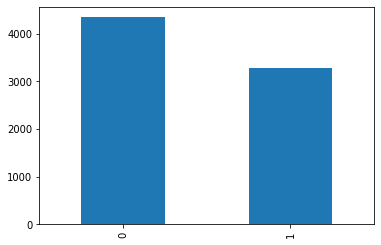

In [11]:
train_dataset['target'].value_counts().plot(kind='bar')

In [12]:
def clean_text(Inpdata):
    cleanedArticle1=re.sub(r'[?|$|(),"".@#=><|!]Â&*/',r' ',Inpdata)
    cleanedArticle2=re.sub(r'https?://\S+|www\.\S+',r' ',cleanedArticle1)
    cleanedArticle3=re.sub(r'[^a-z A-Z]',r' ',cleanedArticle2)
    cleanedArticle4=cleanedArticle3.lower()
    cleanedArticle5=re.sub(r'\b\w{1,2}\b', ' ',cleanedArticle4)
    cleanedArticle6=re.sub(r' +', ' ',cleanedArticle5)
    return(cleanedArticle6)

In [13]:
train_dataset['text_new']=train_dataset['text'].apply(clean_text)
test_dataset['text_new']=test_dataset['text'].apply(clean_text)

In [14]:
train_dataset=train_dataset.drop(labels=['keyword','location','text','id'], axis=1)
test_dataset=test_dataset.drop(labels=['keyword','location','text','id'], axis=1)

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [16]:
TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)

In [17]:
fields = [('label', LABEL),('text',TEXT)]

In [18]:
train_dataset.to_csv('traindf.csv',index=False)
test_dataset.to_csv('testdf.csv',index=False)

In [19]:
training_data=data.TabularDataset(path = '/content/traindf.csv',format = 'csv',fields = fields,skip_header = True)
print(vars(training_data.examples[1]))

{'label': '1', 'text': ['forest', 'fire', 'near', 'ronge', 'sask', 'canada']}


In [20]:
import random
train_data, valid_data = training_data.split(split_ratio=0.7, random_state = random.seed(SEED))

In [21]:
TEXT.build_vocab(train_data,min_freq=3,vectors = "glove.6B.100d")  
LABEL.build_vocab(train_data)
print("Size of TEXT vocabulary:",len(TEXT.vocab))
print("Size of LABEL vocabulary:",len(LABEL.vocab))
print(TEXT.vocab.freqs.most_common(10))  
print(TEXT.vocab.stoi)  



.vector_cache/glove.6B.zip: 862MB [02:43, 5.29MB/s]                           
100%|█████████▉| 398853/400000 [00:18<00:00, 23887.98it/s]

Size of TEXT vocabulary: 3314
Size of LABEL vocabulary: 2
[(' ', 2343), ('the', 2298), ('and', 1005), ('you', 631), ('for', 609), ('that', 438), ('with', 407), ('this', 319), ('are', 294), ('from', 294)]
defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7fab720db1d0>>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'the': 3, 'and': 4, 'you': 5, 'for': 6, 'that': 7, 'with': 8, 'this': 9, 'are': 10, 'from': 11, 'was': 12, 'have': 13, 'amp': 14, 'like': 15, 'just': 16, 'but': 17, 'not': 18, 'your': 19, 'out': 20, 'can': 21, 'all': 22, 'after': 23, 'will': 24, 'has': 25, 'fire': 26, 'what': 27, 'they': 28, 'when': 29, 'now': 30, 'new': 31, 'via': 32, 'about': 33, 'get': 34, 'more': 35, 'news': 36, 'one': 37, 'how': 38, 'people': 39, 'over': 40, 'who': 41, 'there': 42, 'don': 43, 'emergency': 44, 'been': 45, 'into': 46, 'video': 47, 'disaster': 48, 'than': 49, 'her': 50, 'body': 51, 'time': 52, 'would': 53, 'some': 54, 'suicide': 55, 'his': 56, 'police': 57, 'got': 

In [22]:
BATCH_SIZE = 64
train_iterator, valid_iterator = data.BucketIterator.splits((train_data, valid_data), batch_size = BATCH_SIZE,sort_key = lambda x: len(x.text),sort_within_batch=True,device = device)

In [23]:
import torch.nn as nn

class classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()          
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim,  hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout,batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.act = nn.Sigmoid()
        
    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
        dense_outputs=self.fc(hidden)
        outputs=self.act(dense_outputs)
        return outputs

In [24]:
size_of_vocab = len(TEXT.vocab)
embedding_dim = 100
num_hidden_nodes = 32
num_output_nodes = 1
num_layers = 2
bidirection = True
dropout = 0.2

In [25]:
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes,num_output_nodes, num_layers, bidirectional = True, dropout = dropout)

In [26]:
print(model)

classifier(
  (embedding): Embedding(3314, 100)
  (lstm): LSTM(100, 32, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (act): Sigmoid()
)


In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

print(pretrained_embeddings.shape)


The model has 390,857 trainable parameters
torch.Size([3314, 100])


In [28]:
import torch.optim as optim
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()
def binary_accuracy(preds, y):
    rounded_preds = torch.round(preds)
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    

model = model.to(device)
criterion = criterion.to(device)

In [29]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()  
    for batch in iterator:
        optimizer.zero_grad()   
        text, text_lengths = batch.text   
        predictions = model(text, text_lengths).squeeze()  
        loss = criterion(predictions, batch.label)        
        acc = binary_accuracy(predictions, batch.label)   
        loss.backward()       
        optimizer.step()      
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [30]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
       for batch in iterator:
           text, text_lengths = batch.text
           predictions = model(text, text_lengths).squeeze()
           loss = criterion(predictions, batch.label)
           acc = binary_accuracy(predictions, batch.label)
           epoch_loss += loss.item()
           epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [31]:
N_EPOCHS = 5
best_valid_loss = float('inf')
for epoch in range(N_EPOCHS):
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    if valid_loss < best_valid_loss:
       best_valid_loss = valid_loss
       torch.save(model.state_dict(), 'saved_weights.pt')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

	Train Loss: 0.568 | Train Acc: 70.40%
	 Val. Loss: 0.458 |  Val. Acc: 79.34%
	Train Loss: 0.434 | Train Acc: 81.16%
	 Val. Loss: 0.436 |  Val. Acc: 80.34%
	Train Loss: 0.385 | Train Acc: 83.54%
	 Val. Loss: 0.452 |  Val. Acc: 79.84%
	Train Loss: 0.347 | Train Acc: 86.13%
	 Val. Loss: 0.429 |  Val. Acc: 81.73%
	Train Loss: 0.306 | Train Acc: 87.76%
	 Val. Loss: 0.480 |  Val. Acc: 80.00%


In [32]:
model.eval()
import spacy
nlp = spacy.load('en')

def predict(model, sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)] 
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]         
    length = [len(indexed)]                                  
    tensor = torch.LongTensor(indexed).to(device)             
    tensor = tensor.unsqueeze(1).T                            
    length_tensor = torch.LongTensor(length)                  
    prediction = model(tensor, length_tensor)                 
    return prediction.item()        

In [33]:
predict(model, "Are there any sports that you don't like?")


0.047230035066604614